<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Lesson22_RecSys/ML_AI_recsys3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Рекомендательные системы

В этом задании будем практиковаться в реализации рекомендательных систем.

Воспользуемся небольшим датасетом с Kaggle: [Articles Sharing and Reading from CI&T Deskdrop](https://www.kaggle.com/gspmoreira/articles-sharing-reading-from-cit-deskdrop).

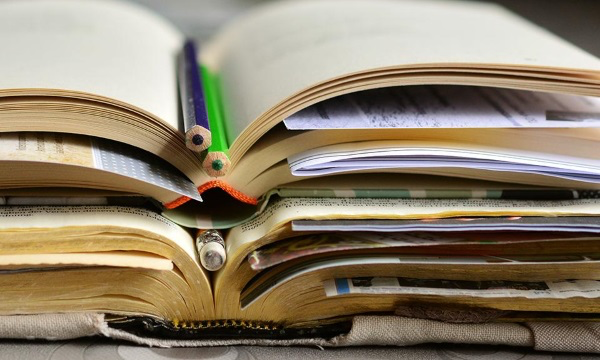

In [1]:
import pandas as pd
import numpy as np
import math

from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook

## Часть 1. Загрузка данных

Загрузим Deskdrop dataset, включающийся в себе информацию за один год платформы, где пользователи читают статьи.

In [2]:
interactions_df = pd.read_csv('https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/users_interactions.csv')
interactions_df.head()

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN


В колонке eventType описаны действия, которые могли совершать пользователи над статьёй:  
- VIEW
- LIKE
- COMMENT CREATED
- FOLLOW
- BOOKMARK

In [3]:
interactions_df.personId = interactions_df.personId.astype(str)
interactions_df.contentId = interactions_df.contentId.astype(str)

### Предобработка данных

В логах встречаются различные действия пользователей. Однако мы хотим работать лишь с одной величиной, характеризующей всё взаимодействие пользователя со статьёй. Предлагается задать действиям следующие веса:

In [4]:
event_type_strength = {
   'VIEW': 1.0,
   'LIKE': 2.0,
   'BOOKMARK': 2.5,
   'FOLLOW': 3.0,
   'COMMENT CREATED': 4.0,
}

Посчитаем числовую величину "оценки" пользователем статьи с указанными выше весами.

In [5]:
interactions_df['eventStrength'] = interactions_df.eventType.apply(lambda x: event_type_strength[x])
interactions_df['eventStrength']

,eventStrength
0,1.0
1,1.0
2,1.0
3,3.0
4,1.0
...,...
72307,2.0
72308,1.0
72309,1.0
72310,1.0


Ремендательные системы подвержены проблеме холодного старта. Будем работать только с теми пользователями, которые взаимодействовали хотя бы с 5-ю материалами.

Оставим только таких пользователей.

In [6]:
users_interactions_count_df = (
    interactions_df
    .groupby(['personId', 'contentId'])
    .first()
    .reset_index()
    .groupby('personId').size())
print('number of users:', len(users_interactions_count_df))

users_with_enough_interactions_df = \
    users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['personId']]
print('number of users with at least 5 interactions:',len(users_with_enough_interactions_df))

number of users: 1895
number of users with at least 5 interactions: 1140


<Axes: >

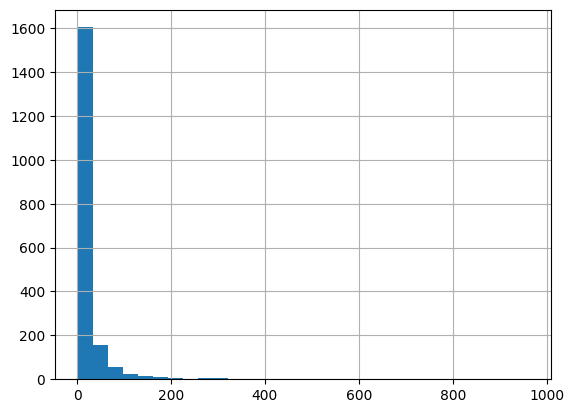

In [7]:
users_interactions_count_df.hist(bins=30)

Оставим только те взаимодействия, которые касаются только отфильтрованных пользователей.

In [8]:
interactions_from_selected_users_df = interactions_df.loc[np.in1d(interactions_df.personId,
            users_with_enough_interactions_df)]

In [9]:
print('number of interactions before:', interactions_df.shape)
print('number of interactions after:', interactions_from_selected_users_df.shape)

number of interactions before: (72312, 9)
number of interactions after: (69868, 9)


В данной постановке каждый пользователей мог взаимодействовать с каждой статьей более одного раза (как минимум совершая различные действия). Предлагается "схлопнуть" все действия в одно взаимодействие с весом, равным сумме весов.

Однако полученное число будет в том числе тем больше, чем больше действий произвел человек. Чтобы уменьшить разброс предлагается взять логарифм от полученного числа (можно придумывать другие веса действиям и по-другому обрабатывать значения).

Также сохраним последнее значение времени взаимодействия для разделениея выборки на обучение и контроль.

In [10]:
def smooth_user_preference(x):
    return math.log(1+x, 2)

interactions_full_df = (
    interactions_from_selected_users_df
    .groupby(['personId', 'contentId']).eventStrength.sum()
    .apply(smooth_user_preference)
    .reset_index().set_index(['personId', 'contentId'])
)
interactions_full_df['last_timestamp'] = (
    interactions_from_selected_users_df
    .groupby(['personId', 'contentId'])['timestamp'].last()
)

interactions_full_df = interactions_full_df.reset_index()
interactions_full_df.head()

,personId,contentId,eventStrength,last_timestamp
0,-1007001694607905623,-5065077552540450930,1.000000,1470395911
1,-1007001694607905623,-6623581327558800021,1.000000,1487240080
2,-1007001694607905623,-793729620925729327,1.000000,1472834892
3,-1007001694607905623,1469580151036142903,1.000000,1487240062
4,-1007001694607905623,7270966256391553686,1.584963,1485994324


Разобьём выборку на обучение и контроль по времени.

In [11]:
split_ts = 1475519530
interactions_train_df = interactions_full_df.loc[interactions_full_df.last_timestamp < split_ts].copy()
interactions_test_df = interactions_full_df.loc[interactions_full_df.last_timestamp >= split_ts].copy()

print('number of interactions on Train set: %d' % len(interactions_train_df))
print('number of interactions on Test set: %d' % len(interactions_test_df))

interactions_train_df

number of interactions on Train set: 29329
number of interactions on Test set: 9777


,personId,contentId,eventStrength,last_timestamp
0,-1007001694607905623,-5065077552540450930,1.0,1470395911
2,-1007001694607905623,-793729620925729327,1.0,1472834892
6,-1032019229384696495,-1006791494035379303,1.0,1469129122
7,-1032019229384696495,-1039912738963181810,1.0,1459376415
8,-1032019229384696495,-1081723567492738167,2.0,1464054093
...,...,...,...,...
39099,997469202936578234,9112765177685685246,2.0,1472479493
39100,998688566268269815,-1255189867397298842,1.0,1474567164
39101,998688566268269815,-401664538366009049,1.0,1474567449
39103,998688566268269815,6881796783400625893,1.0,1474567675


Для удобства подсчёта качества запишем данные в формате, где строка соответствует пользователю, а столбцы будут истинными метками и предсказаниями в виде списков.

In [12]:
interactions = (
    interactions_train_df
    .groupby('personId')['contentId'].agg(lambda x: list(x))
    .reset_index()
    .rename(columns={'contentId': 'true_train'})
    .set_index('personId')
)

interactions['true_test'] = (
    interactions_test_df
    .groupby('personId')['contentId'].agg(lambda x: list(x))
)

interactions.loc[pd.isnull(interactions.true_test), 'true_test'] = [
    [''] for x in range(len(interactions.loc[pd.isnull(interactions.true_test), 'true_test']))]

interactions.head(5)

,true_train,true_test
personId,,
-1007001694607905623,"[-5065077552540450930, -793729620925729327]","[-6623581327558800021, 1469580151036142903, 72..."
-1032019229384696495,"[-1006791494035379303, -1039912738963181810, -...","[-1415040208471067980, -2555801390963402198, -..."
-108842214936804958,"[-1196068832249300490, -133139342397538859, -1...","[-2780168264183400543, -3060116862184714437, -..."
-1130272294246983140,"[-1150591229250318592, -1196068832249300490, -...","[-1606980109000976010, -1663441888197894674, -..."
-1160159014793528221,"[-133139342397538859, -387651900461462767, 377...",[-3462051751080362224]


## Метрика качества

Качество модели будем оценивать при помощи метрики precision@10 для каждого пользователя (доля угаданных рекомендаций). Усредним ее по всем пользователям.

In [13]:
def calc_precision(column):
    return (
        interactions
        .apply(
            lambda row:
            len(set(row['true_test']).intersection(
                set(row[column]))) /
            min(len(row['true_test']) + 0.001, 10.0),
            axis=1)).mean()

Составим матрицу "оценок" пользователей. Нули будут обозначать отсутствие взаимодействия.

In [14]:
ratings = pd.pivot_table(
    interactions_train_df,
    values='eventStrength',
    index='personId',
    columns='contentId').fillna(0)

## Часть 2. Контентные  модели

В этой части реализуем альтернативный подход к рекомендательным системам — контентные модели.

Теперь мы будем оперировать не матрицей с оценками, а классической для машинного обучения матрицей объекты-признаки. Каждый объект будет характеризовать пару user-item и содержать признаки, описывающие как пользователя, так и товар. Кроме этого признаки могут описывать и саму пару целиком.

Матрица со всеми взаимодействиями уже получена нами на этапа разбиения выборки на две части.

* Будем обучать классификатор на взаимодействие, а для него нужны отрицательные примеры. Добавим случайные отсутствующие взаимодействия как отрицательные

* Заметим, что модель оценивает каждую пару потенциального взаимодействия, а значит, надо подготовить выборку из всех возможных пар из пользователей и статей

In [15]:
test_personId = np.repeat(interactions.index, len(ratings.columns))
test_contentId = list(ratings.columns) * len(interactions)
test = pd.DataFrame(
    np.array([test_personId, test_contentId]).T,
    columns=['personId', 'contentId'])

interactions_train_df = pd.concat((
    interactions_train_df,
    test.loc[
        np.random.permutation(test.index)[
            :4*len(interactions_train_df)]]), ignore_index=True)
interactions_train_df.eventStrength.fillna(0, inplace=True)

<ipython-input-15-0743bb745623>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  interactions_train_df.eventStrength.fillna(0, inplace=True)


Загрузим метаинформацию о статьях.

Сразу оставим только информацию о статьях, отображающихся на сайте (`CONTENT SHARED`), так как бесполезно рекомендовать удаленные статьи.

In [16]:
articles_df = pd.read_csv("https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/shared_articles.csv")

articles_df = articles_df[articles_df['eventType'] == 'CONTENT SHARED']
articles_df.head(2)

articles_df.contentId = articles_df.contentId.astype(str)

In [17]:
articles_df.head(2)

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en


Придумаем и добавим признаков о пользователях и статьях. Сначала добавим информацию о статьях в данные о взаимодействиях.

In [18]:
interactions_train_df = interactions_train_df.merge(articles_df, how='left', on='contentId')
interactions_test_df = interactions_test_df.merge(articles_df, how='left', on='contentId')

In [19]:
features_start = len(interactions_train_df.columns)

После обучения модели нам придётся делать предсказания на тестовой выборке для всех возможных пар статья-пользователь. Подготовим такую матрицу, чтобы параллельно посчитать признаки для неё.

In [20]:
test_personId = np.repeat(interactions.index, len(articles_df))
test_contentId = list(articles_df.contentId) * len(interactions)
test = pd.DataFrame(
    np.array([test_personId, test_contentId]).T,
    columns=['personId', 'contentId'])
test = test.merge(articles_df, how='left', on='contentId')

test.head()

,personId,contentId,timestamp,eventType,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
0,-1007001694607905623,-4110354420726924665,1459193988,CONTENT SHARED,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,-1007001694607905623,-7292285110016212249,1459194146,CONTENT SHARED,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
2,-1007001694607905623,-6151852268067518688,1459194474,CONTENT SHARED,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
3,-1007001694607905623,2448026894306402386,1459194497,CONTENT SHARED,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en
4,-1007001694607905623,-2826566343807132236,1459194522,CONTENT SHARED,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en


Добавим признаки-индикаторы возможных значений contentType.

In [21]:
interactions_train_df['is_HTML'] = interactions_train_df.contentType == 'HTML'
interactions_train_df['is_RICH'] = interactions_train_df.contentType == 'RICH'
interactions_train_df['is_VIDEO'] = interactions_train_df.contentType == 'VIDEO'

test['is_HTML'] = test.contentType == 'HTML'
test['is_RICH'] = test.contentType == 'RICH'
test['is_VIDEO'] = test.contentType == 'VIDEO'

Добавим признаки "длина названия" и "длина текста" + некоторые проверки на ключевые слова.

In [22]:
interactions_train_df['title_length'] = interactions_train_df.title.fillna('').apply(len)
interactions_train_df['text_length'] = interactions_train_df.text.fillna('').apply(len)

test['title_length'] = test.title.fillna('').apply(len)
test['text_length'] = test.text.fillna('').apply(len)

interactions_train_df['has_new'] = \
    interactions_train_df.title.fillna('').apply(lambda x: 'new' in x.lower())
interactions_train_df['has_why'] = \
    interactions_train_df.title.fillna('').apply(lambda x: 'why' in x.lower())
interactions_train_df['has_how'] = \
    interactions_train_df.title.fillna('').apply(lambda x: 'how' in x.lower())
interactions_train_df['has_ai'] = \
    interactions_train_df.title.fillna('').apply(lambda x: 'ai' in x.lower())

test['has_new'] = \
    test.title.fillna('').apply(lambda x: 'new' in x.lower())
test['has_why'] = \
    test.title.fillna('').apply(lambda x: 'why' in x.lower())
test['has_how'] = \
    test.title.fillna('').apply(lambda x: 'how' in x.lower())
test['has_ai'] = \
    test.title.fillna('').apply(lambda x: 'ai' in x.lower())

Добавим признаки-индикаторы языка.

In [23]:
interactions_train_df['is_lang_en'] = interactions_train_df.lang == 'en'
interactions_train_df['is_lang_pt'] = interactions_train_df.lang == 'pt'

test['is_lang_en'] = test.lang == 'en'
test['is_lang_pt'] = test.lang == 'pt'

Обучим на полученных признаках градиентный бустинг.

In [24]:
!pip install catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.7 MB/s eta 0:00:00


Будем использовать в модели только сгенерированные признаки.

In [25]:
interactions_train_df[interactions_train_df.columns[features_start:]]

,is_HTML,is_RICH,is_VIDEO,title_length,text_length,has_new,has_why,has_how,has_ai,is_lang_en,is_lang_pt
0,True,False,False,63,655,False,False,False,True,False,True
1,True,False,False,30,2495,False,False,False,False,True,False
2,True,False,False,89,1221,False,False,False,False,True,False
3,True,False,False,102,801,False,False,False,False,True,False
4,True,False,False,74,1860,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...
146640,True,False,False,49,9603,False,False,False,False,True,False
146641,True,False,False,64,5627,False,False,False,False,True,False
146642,True,False,False,47,1313,False,False,False,True,False,True
146643,True,False,False,56,1611,False,False,False,False,True,False


Обучаем классификатор на прогноз взаимодействия пользователя и статьи.

In [26]:
import catboost

model = catboost.CatBoostClassifier()
model.fit(interactions_train_df[interactions_train_df.columns[features_start:]],
          np.array(interactions_train_df.eventStrength > 0, dtype=int))

Learning rate set to 0.086682
0:	learn: 0.6577954	total: 79.6ms	remaining: 1m 19s
1:	learn: 0.6290962	total: 101ms	remaining: 50.2s
2:	learn: 0.6051518	total: 133ms	remaining: 44.1s
3:	learn: 0.5859233	total: 154ms	remaining: 38.3s
4:	learn: 0.5698955	total: 192ms	remaining: 38.3s
5:	learn: 0.5569175	total: 219ms	remaining: 36.2s
6:	learn: 0.5459737	total: 244ms	remaining: 34.6s
7:	learn: 0.5371394	total: 269ms	remaining: 33.4s
8:	learn: 0.5300217	total: 288ms	remaining: 31.7s
9:	learn: 0.5242120	total: 313ms	remaining: 31s
10:	learn: 0.5192437	total: 337ms	remaining: 30.3s
11:	learn: 0.5149077	total: 365ms	remaining: 30.1s
12:	learn: 0.5112380	total: 398ms	remaining: 30.2s
13:	learn: 0.5083109	total: 423ms	remaining: 29.8s
14:	learn: 0.5060057	total: 443ms	remaining: 29.1s
15:	learn: 0.5041039	total: 466ms	remaining: 28.7s
16:	learn: 0.5022416	total: 491ms	remaining: 28.4s
17:	learn: 0.5009244	total: 512ms	remaining: 28s
18:	learn: 0.4997076	total: 539ms	remaining: 27.8s
19:	learn: 0.

Сделаем предсказания на тестовой выборке, сформируем из них рекомендации:

будем рекомендовать пользователю статьи, для которых модель спрогнозировала наибольшую вероятность взаимодействия.

In [27]:
top_k = 10

predictions = model.predict_proba(test[interactions_train_df.columns[features_start:]])[:, 1]
test['predictions'] = predictions

test = test.sort_values('predictions', ascending=False)
predictions = test.groupby('personId')['contentId'].aggregate(list)
tmp_predictions = []

for personId in tqdm_notebook(interactions.index):
    prediction = np.array(predictions.loc[personId])

    tmp_predictions.append(
        list(prediction[~np.in1d(
            prediction,
            interactions.loc[personId, 'true_train'])])[:top_k])

interactions['prediction_content'] = tmp_predictions

<ipython-input-27-104d42c29fab>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for personId in tqdm_notebook(interactions.index):


  0%|          | 0/1112 [00:00<?, ?it/s]

Оценим их качество.

In [28]:
calc_precision('prediction_content')

0.007337405374702384

## Часть 3. Факторизационная машина

Вспомним, что факторизационная машина учитывает попарные взаимодействия признаков, что приводит сразу и к использованию контента (сами признаки), и к обучению скрытых представлений (индикаторы пользователей и статей).

Попробуем факторизационные машины из библиотеки fastFM.

In [32]:
!pip install fastFM

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastFM: filename=fastFM-0.2.10-cp311-cp311-linux_x86_64.whl size=625904 sha256=74d7f2e6b844870def90d1f8ef96ec1fb27c31a4c0f261dffe018ba67ca1dc7b
  Stored in directory: /root/.cache/pip/wheels/2c/7e/87/e3b3c36cb0f43f6e583663f16e211a71ac0833090379911750
Successfully built fastFM


In [33]:
from fastFM import als

Перейдём к обобщению матричных разложений — факторизационным машинам, которые могут работать с контентной информацией. Вспомним, какие данные у нас изначально были:

В факторизационную машину можно загрузить "айдишники" пользователей и статей (то есть сделать аналог коллаборативной фильтрации) и одновременно различные признаки.

Удобно обрабатывать категориальные переменные (id и другие) можно с помощью DictVectorizer. Например, процесс может выглядеть вот так:
```python
train = [
    {"user": "1", "item": "5", "age": 19},
    {"user": "2", "item": "43", "age": 33},
    {"user": "3", "item": "20", "age": 55},
    {"user": "4", "item": "10", "age": 20},
]
v = DictVectorizer()
X = v.fit_transform(train)
y = np.repeat(1.0, X.shape[0])
fm = als.FMRegression()
fm.fit(X,y)
fm.predict(v.transform({"user": "1", "item": "10", "age": 24}))
```

Сгенерируем таблицу с признаками в таком виде, где будут id пользователя, статьи и автора статьи и несколько признаков, которые вы сможете придумать.

In [36]:
train_data = []

for i in tqdm_notebook(range(len(interactions_train_df))):
    features = {}
    features['personId'] = str(interactions_train_df.iloc[i].personId)
    features['contentId'] = str(interactions_train_df.iloc[i].contentId)
    try:
        article = articles_df.loc[features['contentId']]
        features['authorId'] = str(article.authorPersonId)
        features['authorCountry'] = str(article.authorCountry)
        features['lang'] = str(article.lang)
    except:
        features['authorId'] = 'unknown'
        features['authorCountry'] = 'unknown'
        features['lang'] = 'unknown'

    train_data.append(features)

<ipython-input-36-8b108631fc4f>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(interactions_train_df))):


  0%|          | 0/146645 [00:00<?, ?it/s]

Повторим эту процедуру для тестовой выборки. Заметим, что модель оценивает каждую пару потенциального взаимодействия, а значит, надо подготовить выборку из всех возможных пар из пользователей и статей.

In [37]:
test_data = []

for i in tqdm_notebook(range(len(interactions))):
    features = {}
    features['personId'] = str(interactions.index[i])
    for j in range(len(ratings.columns)):
        features['contentId'] = str(ratings.columns[j])

        try:
            article = articles_df.loc[features['contentId']]
            features['authorId'] = str(article.authorPersonId)
            features['authorCountry'] = str(article.authorCountry)
            features['lang'] = str(article.lang)
        except:
            features['authorId'] = 'unknown'
            features['authorCountry'] = 'unknown'
            features['lang'] = 'unknown'

        test_data.append(deepcopy(features))

<ipython-input-37-b631575303ef>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(interactions))):


  0%|          | 0/1112 [00:00<?, ?it/s]

Векторизуем, получим разреженные матрицы.

Мы будем обучать регрессор на силу взаимодействия, а для него нужны отрицательные примеры. Добавим некоторое количество случайных примеров как негативные (матрица взаимодействий разреженная, поэтому шансы взять как негативное взаимодействие некоторое положительное мало).

In [38]:
dv = DictVectorizer()

train_features = dv.fit_transform(
    train_data + list(np.random.permutation(test_data)[:100000]))
test_features = dv.transform(test_data)

In [39]:
train_features

<246645x3481 sparse matrix of type '<class 'numpy.float64'>'
	with 1233225 stored elements in Compressed Sparse Row format>

In [41]:
y_train = np.array(list(interactions_train_df.eventStrength.values) + list(np.zeros(100000)))

### Гиперпараметры регрессии в fastFM

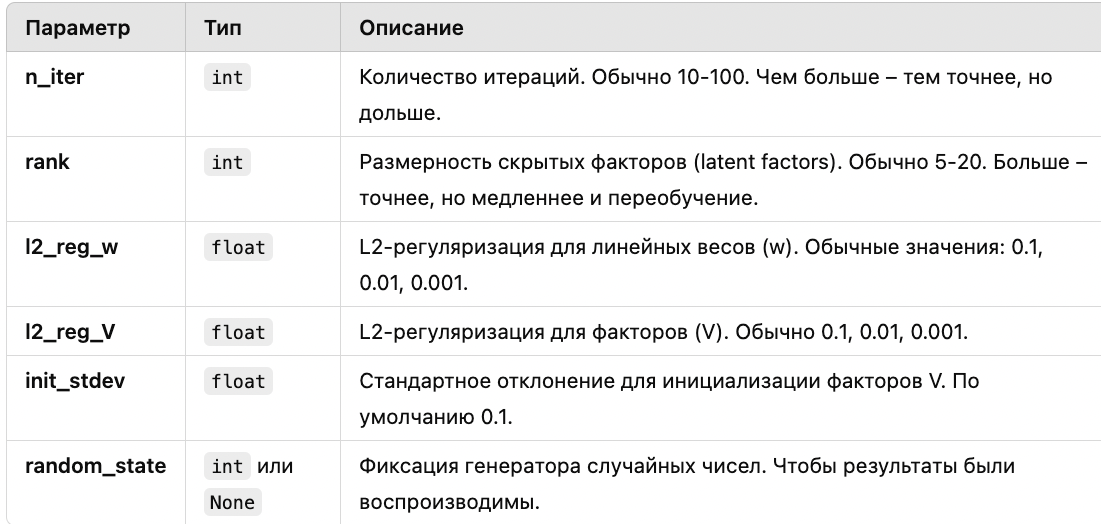

In [42]:
# Инициализация и обучение модели
fm = als.FMRegression(n_iter=30, rank=10, l2_reg_w=0.1, l2_reg_V=0.5)
fm.fit(train_features, y_train)

# Предсказания
y_predict = fm.predict(test_features)
new_ratings = y_predict.reshape((len(interactions), len(ratings.columns)))

# Формирование рекомендаций
predictions = []

top_k = 10
for i, person in enumerate(interactions.index):
    user_prediction = ratings.columns[np.argsort(new_ratings[i])[::-1]]
    predictions.append(user_prediction[~np.in1d(user_prediction, interactions.loc[person, 'true_train'])][:top_k])

interactions['fm_prediction'] = predictions

In [43]:
calc_precision('fm_prediction')

0.006460368606568671